# Metropolis-Hastings (MH) algorithms

These algorithms are a series of procedures that help us to draw samples from a target distributions which is known up to a normalizing constant. This type of problems present when dealing with *Bayesian inference*, where the posterior distribution is not fully known because the integration to compute the normalizing constant has to be solved numerically.


## Problem: 

Given a target distribution (density $p$) from which we one to draw samples and which we know up to a normilizing constant, we construct a Markov process whose distribution is $p$.

The core of these and other algorithms is the procedure to build the Markov chain.

The idea behind the MH algorithms is the following: Given the target density $p$ there is an associated conditional density $q$ which is easier to simulate. The MH algorithm for the target $p$ and conditional density $q$ produces a Markov chain $\{X_{t} \}$ whose, as we already mention,  stationary distribution is $p$.

The algorithm follows the steps:

1. Initialize a value $x_0$ (first sample)
2. Generate a value from a random variable $Y_0$ with distribution $q(y|x_0)$
3. Define

    $$
    X_1 = \begin{cases}
        & Y_0 \qquad \text{with probaility } \rho(x_0, Y_0)\\
        & x_0 \qquad \text{with probaility } 1 - \rho(x_0, Y_0)
    \end{cases}
    $$
4. Repeat steps 2 and 3 "sufficiently enough".

where 
    $$
        \rho(x,y) = \min\left\{\frac{p(y)}{p(x)}\frac{q(x|y)}{q(y|x)}, 1 \right\}
    $$

Repetition of steps 2 and 3 will define a sequence of random variables $X_t$ such that $X_0 = x_0$ with probability 1. This sequence is a Markov process. The prove of this fact will be done later in this notebook.

From now on wi will denote $p \propto f$ for $p(x) = \frac{f(x)}{\int_{\mathbb R} f(y)dy}$. This implies that $\frac{p(x)}{p(y)} = \frac{f(x)}{f(y)}$.


**Result** The importanceof this algorithm is the fact that the Markov process $(X_t)$ it produces has $f$ (or more precisely $p$) as a stationary distribution. That is, for large values of $t$, $X^t \sim f$.

## Implementing the MH algorithm

In [1]:
import numpy as np
import scipy.stats
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
scipy.stats.norm.rvs(size = 1)

array([-0.01738963])

In [46]:
def MetropolisHasting(target, conditional, simulate_conditional,num_iter =1000):
    
    """
    This function returns the Markov chain for the target distribution
    and conditional distribution.

    Args:
    -----
    target: function object. The target distribution
    conditional: function object. The conditional distribution
    num_iter: int. The number of iterations.
    """
    
    x0 = scipy.stats.uniform.rvs(size = 1)

    X = np.zeros(num_iter)
    X[0] = x0
    accept = 0

    for t in range(1, num_iter):
        
        y = simulate_conditional(X[t-1])

        u = scipy.stats.uniform.rvs(size = 1)
        rho = target(y)/target(X[t-1]) * conditional(X[t-1])/conditional(y)

        if u<= rho :
            X[t] = y
            accept += 1
        else:
            X[t] = X[t-1]

    acceptance_ratio = accept/num_iter

    return X, acceptance_ratio
    

## Examples:

1. Let's simulate a beta distribution $\mathcal{B}(\alpha, \beta)$ with $\alpha =2.7$, $\beta =6.3$ using this algorithm, with conditional distribution the Uniform distribution in $[0,1]$. In this case the conditional distribution does not deppend of the previous value $x^{t-1}$.

In [47]:
a = 2.7
b = 6.3
def conditional(y):

    if y >=0 and y<=1:
        return 1
    else:
        return 0
    
def target(x):

    return scipy.stats.beta.pdf(x, a = 2.7, b= 6.3)

def simulate_conditional(x):

    return scipy.stats.uniform.rvs(loc =0, scale =1, size =1)



In [60]:
num_iter = 10**3

X, acceptance_ration = MetropolisHasting(target, conditional, simulate_conditional, num_iter)


In [61]:
acceptance_ration

0.477

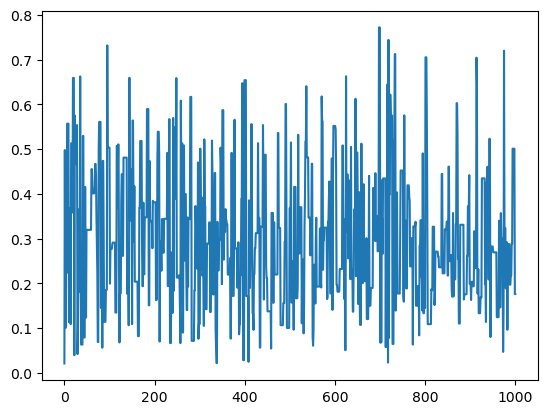

In [62]:
plt.plot(np.linspace(0, num_iter, num_iter), X)


In [63]:
import seaborn as sns

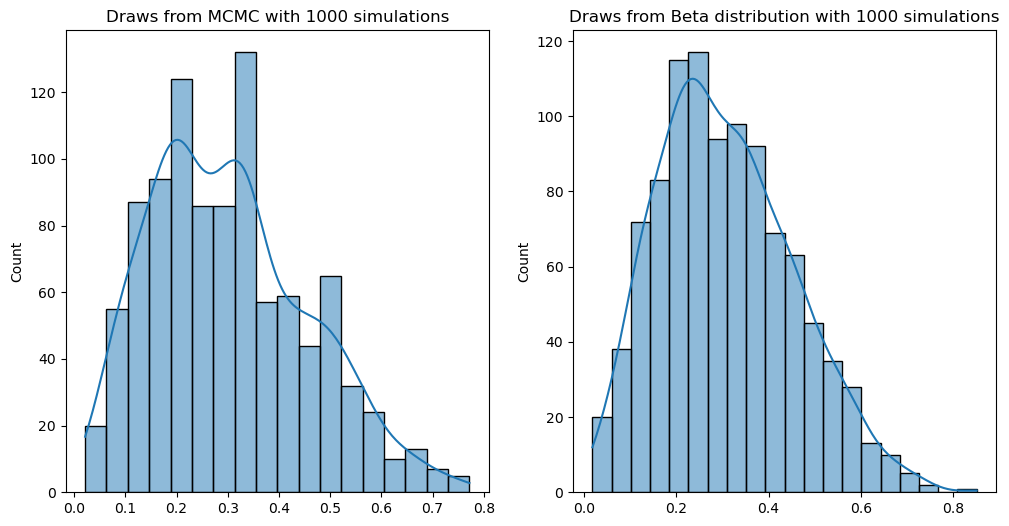

In [64]:
B = scipy.stats.beta.rvs(a = 2.7, b = 6.3, size = num_iter)

plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(X, kde=True)
plt.title(f"Draws from MCMC with {num_iter} simulations")
plt.subplot(122)
sns.histplot(B, kde=True)
plt.title(f"Draws from Beta distribution with {num_iter} simulations")
plt.show()


Simulating 10000 times:

In [65]:
num_iter = 10**4

X, acceptance_ratio = MetropolisHasting(target, conditional, simulate_conditional, num_iter)
B = scipy.stats.beta.rvs(a = 2.7, b = 6.3, size = num_iter)


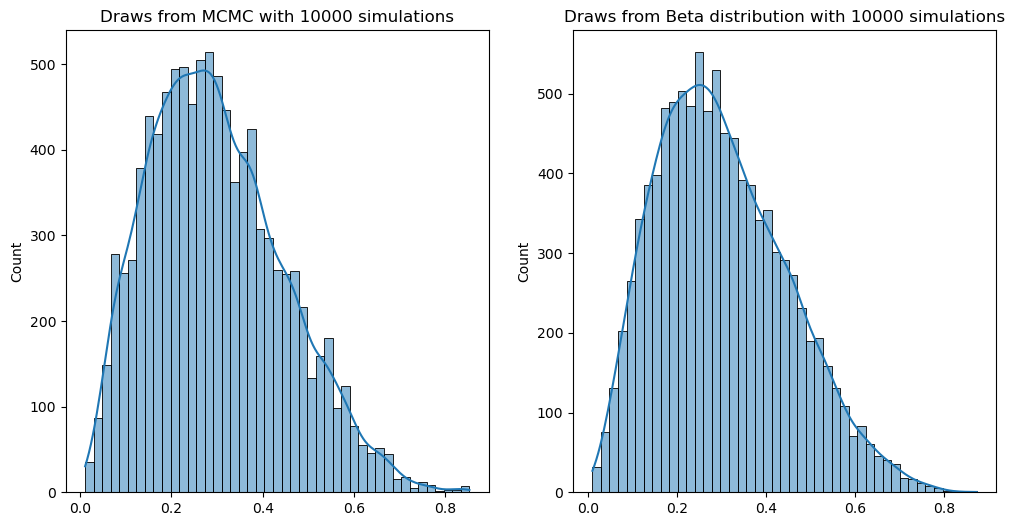

In [66]:


plt.figure(figsize=(12, 6))
plt.subplot(121)
sns.histplot(X, kde=True)
plt.title(f"Draws from MCMC with {num_iter} simulations")
plt.subplot(122)
sns.histplot(B, kde=True)
plt.title(f"Draws from Beta distribution with {num_iter} simulations")
plt.show()


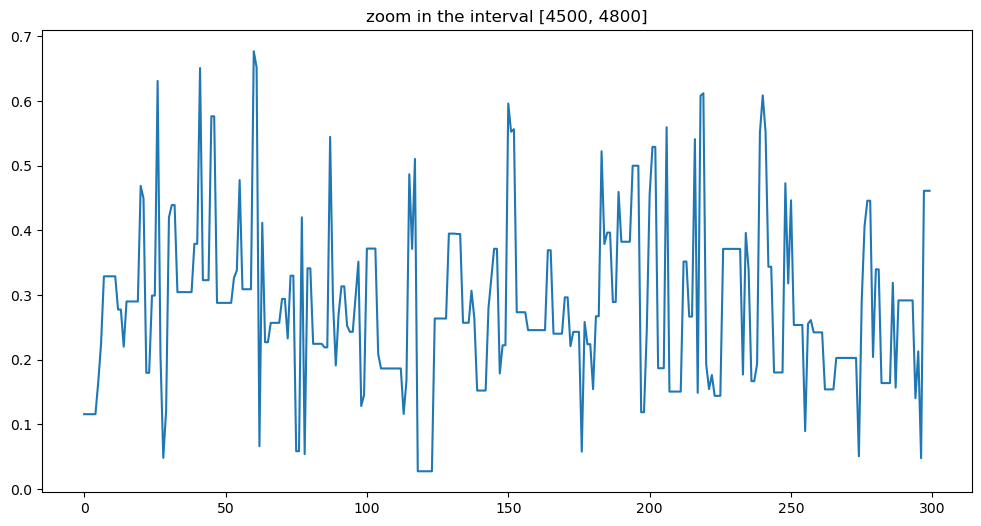

In [68]:
plt.figure(figsize=(12, 6))
plt.plot(X[4500:4800])
plt.title("zoom in the interval [4500, 4800]")
plt.show()

Lets make a table with several number of simulations and compare the mean and the variance of the sample generated by the algorithm and the sample generated by the distribution Beta itself.


In [78]:
Num_iters = [10**2, 10**3, 10**4, 10**5]
df = pd.DataFrame({}, columns=["num_simulations", "sample mean of X_t", "True mean", "sample variance of X_t", "True variance"], index= np.arange(len(Num_iters)))

df


,num_simulations,sample mean of X_t,True mean,sample variance of X_t,True variance
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN


In [82]:
for i, num_iter in enumerate(Num_iters):
    X, _ = MetropolisHasting(target, conditional, simulate_conditional, num_iter)
    B = scipy.stats.beta.rvs(a = 2.7, b = 6.3, size = num_iter)
    df.iloc[i]["num_simulations"] = num_iter
    df.iloc[i]["sample mean of X_t"] = X.mean()
    df.iloc[i]["sample variance of X_t"] = (X.std())**2


In [83]:
df["True mean"] = a/(a+b)
df["True variance"] = a*b/((a+b)**2 * (a +b +1))

df


,num_simulations,sample mean of X_t,True mean,sample variance of X_t,True variance
0,100,0.372573,0.3,0.024019,0.021
1,1000,0.309909,0.3,0.023799,0.021
2,10000,0.299219,0.3,0.020711,0.021
3,100000,0.299064,0.3,0.020891,0.021
